In [276]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

import pandas as pd

In [277]:
# !pip install scikit-learn

In [278]:
from cfollmer.objectives import log_g, relative_entropy_control_cost, stl_relative_entropy_control_cost_xu
from cfollmer.sampler_utils import FollmerSDE
from cfollmer.trainers import basic_batched_trainer

# The Model

\begin{align}
\theta &\sim \mathcal{N}(\theta | 0, \sigma_w^2 \mathbb{I}) \\
y_i | x_i, \theta &\sim  \mathrm{Bernouli}\left[\mathrm{NN}_{\theta}\left(x_i \right)\right]
\end{align}

We want samples from $p(\theta | \{(y_i, x_i)\})$. Note $f(x; \theta)$ is a neural net with params $\theta$

## Loading the iris dataset

In [279]:
a9a_train = pd.read_csv("../data/a9a.csv", header=None)
a9a_test = pd.read_csv("../data/a9a_t.csv", header=None)

In [280]:
X_train, y_train = a9a_train.values[:,:-1],  a9a_train.values[:,-1]
X_test, y_test = a9a_test.values[:,:-1],  a9a_test.values[:,-1]

# X_train = np.concatenate((X_train, np.ones((X_train.shape[0],X_train.shape[1]))), axis=1)
# X_test = np.concatenate((X_test, np.ones((X_test.shape[0],X_train.shape[1]))), axis=1)


import sklearn.linear_model
from sklearn.linear_model import LogisticRegression

mod = sklearn.linear_model.LogisticRegression(random_state=0).fit(X_train, y_train)
print(mod.score(X_train, y_train))
print(mod.score(X_test, y_test))

0.8490832591136636
0.8497635280388183


/home/fav25/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [281]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

In [282]:
X_train.shape

torch.Size([32561, 123])

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Controlled Schrodinger Follmer Sampler

The objevtive we are trying to implement is:

\begin{align}
  \mathbf{u}_t^{*}=  \argmin_{\rvu_t \in \mathcal{U}}\mathbb{E}\left[\frac{1}{2\gamma}\int_0^1||\rvu(t, \Theta_t)||^2 dt - \ln\left(\frac{ p(\mX | \Theta_1)p(\Theta_1)}{\mathcal{N}(\Theta_1|\mathbf{0}, \gamma \mathbb{I} )}\right)\right] \
\end{align}

Where:
\begin{align}
d\Theta_t = \rvu(t, \Theta_t)dt + \sqrt{\gamma} dB_t
\end{align}

To do so we use the EM discretisation.

In [283]:
import torch.nn.functional as F


class ClassificationNetwork(object):
    
    def __init__(
        self, input_dim=1, output_dim=1, depth=None,
        width=20, width_seq=None, device="cpu", activation=F.relu
    ):
        
        self.device = device
        self.output_dim = output_dim
        self.input_dim = input_dim 
        self.activation = activation
        
        self.depth = depth
        if not self.depth:
            self.depth = 1
        if not width_seq:
            self.width = width
            self.width_seq = [self.width] * (self.depth + 1)
            self.shapes = [(self.width_seq[i-1], self.width_seq[i])  for i in range(1,self.depth)]
            self.shapes += [(self.width_seq[-1], self.output_dim)]
            self.shapes = [(self.input_dim, self.width_seq[0])] + self.shapes
        
        self.dim = sum([wx * wy + wy for wx, wy in self.shapes])
        
    def forward(self, x, Θ):
        index = 0
        n, d = x.shape
        
#         dim_bl =  sum([wx * wy + wy for wx, wy in self.shapes[:-1]])
#         Θ[:dim_bl] = (Θ[:dim_bl] - Θ[:dim_bl].mean()) / Θ[:dim_bl].std()
#         σ_Θ, μ_Θ = Θ.std(), Θ.mean()
#         Θ = (Θ - μ_Θ) / σ_Θ

        for wx, wy in self.shapes[:-1]:
            x = F.linear(
                x,
                Θ[index: index + wx * wy].reshape(wy, wx),
                Θ[index + wx * wy: index + wx * wy + wy].reshape(1,wy)
            )
            x = self.activation(x)
            index += wx * wy  + wy
        wx, wy = self.shapes[-1]
        x = F.linear(
            x,
            Θ[index: index + wx * wy].reshape(wy, wx), #* σ_Θ + μ_Θ,
            Θ[index + wx * wy: index + wx * wy + wy].reshape(1,wy) # * σ_Θ + μ_Θ
        )
        return x.to(self.device)
    
    def map_forward(self, x, Θ):
        preds_func = lambda θ: self.forward(x, θ)
        batched_preds = torch._vmap_internals.vmap(preds_func)
        preds = torch.hstack(list(map(preds_func, Θ)))
        return preds

In [292]:
class LinearClassifier(object):
    
    def __init__(
        self, input_dim=1, output_dim=1, device="gpu",
    ):
        
        self.device = device
        self.output_dim = output_dim
        self.input_dim = input_dim 
        

        self.shapes = [(self.input_dim, self.output_dim)] 
        
        self.dim = sum([wx * wy + wy for wx, wy in self.shapes])
        
    def forward(self, x, Θ):
        wx, wy = self.shapes[-1]
        x = F.linear(
            x,
            Θ[:wx * wy].reshape(wy, wx),
            Θ[wx * wy: wx * wy + wy].reshape(1,wy)
        )
        return x.to(self.device)
    
    def map_forward(self, x, Θ):
        preds_func = lambda θ: self.forward(x, θ)
        batched_preds = torch._vmap_internals.vmap(preds_func)
        preds = torch.hstack(list(map(preds_func, Θ)))
        return preds
        

In [459]:
class SimpleForwardNetBN_larger(torch.nn.Module):

    def __init__(self, input_dim=1, width=250, activation=torch.nn.Softplus):
        super(SimpleForwardNetBN_larger, self).__init__()
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim + 1, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, input_dim )
        )
        
        self.nn[-1].weight.data.fill_(0.0)
        

    def forward(self, x):
        return self.nn(x)

In [460]:
dim = X_train.shape[1]

net = ClassificationNetwork(
    dim,1, device=device, depth=1, width=30, activation=F.tanh
)


net = LinearClassifier(
    dim,1, device=device
)


def gaussian_prior(Θ, σ_w=2.8):
    """
    Logistic regresion bayesian prior
    """
    return -0.5 * (Θ**2).sum(axis=1) / σ_w

def laplace_prior(Θ, σ_w=1):
    """
    Logistic regresion bayesian prior
    """
    return -(torch.abs(Θ) ).sum(axis=1) / σ_w


def log_likelihood_vmap_nn(Θ, X, y, net=net):
    """
    Hoping this implementation is less buggy / faster
    
    still feels a bit slow.
    """
    pos_weights = torch.ones(X.shape[0], device=device)
    
    def loss(θ):
        preds = net.forward(X, θ)
        bce = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights, reduction="sum")
        ll_bcs = -1.0 * bce(preds.reshape(-1), y.reshape(-1))
        return ll_bcs
    
    batched_loss =  torch._vmap_internals.vmap(loss)

    return batched_loss(Θ)

In [461]:
net.dim, 1/Δt

(124, 100.0)

In [473]:
γ =  0.2
Δt=0.01

dim= net.dim

prior = laplace_prior

sde, losses = basic_batched_trainer(
    γ, Δt, prior, log_likelihood_vmap_nn, dim, X_train, y_train,
    method="euler", stl="stl_xu", adjoint=False, optimizer=None,
    num_steps=85, batch_size_data=int(X_train.shape[0]), batch_size_Θ=20,
    batchnorm=True, device=device, lr=0.002, drift=SimpleForwardNetBN_larger
)

<ipython-input-460-6511ec892fb4>:40: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_loss =  torch._vmap_internals.vmap(loss)


0.7533348202705383
1.3288285732269287
1.0855001211166382
0.5205703377723694
0.4099160134792328
0.6881771087646484
0.7859485745429993
0.5115951299667358
0.41827741265296936
0.46622371673583984
0.5500982999801636
0.6066301465034485
0.5604962110519409
0.43330395221710205
0.39532479643821716
0.42984074354171753
0.4664943814277649
0.47527876496315
0.41772395372390747
0.37468576431274414
0.40581822395324707
0.4311576783657074
0.45866620540618896
0.3916395902633667
0.3658023476600647
0.3970146179199219
0.43644651770591736
0.3916533291339874
0.3597484529018402
0.4072249233722687
0.42455360293388367
0.3885144889354706
0.37544044852256775
0.37342578172683716
0.3947857916355133
0.39697471261024475
0.36064448952674866
0.3717248737812042
0.37650036811828613
0.37192386388778687
0.3656264543533325
0.352934330701828
0.3553847372531891
0.36172977089881897
0.355183482170105
0.36002546548843384
0.35896193981170654
0.35662615299224854
0.3577728569507599
0.351711243391037
0.3560577630996704
0.3550380468368

In [484]:
losses

[tensor(0.7533),
 tensor(1.3288),
 tensor(1.0855),
 tensor(0.5206),
 tensor(0.4099),
 tensor(0.6882),
 tensor(0.7859),
 tensor(0.5116),
 tensor(0.4183),
 tensor(0.4662),
 tensor(0.5501),
 tensor(0.6066),
 tensor(0.5605),
 tensor(0.4333),
 tensor(0.3953),
 tensor(0.4298),
 tensor(0.4665),
 tensor(0.4753),
 tensor(0.4177),
 tensor(0.3747),
 tensor(0.4058),
 tensor(0.4312),
 tensor(0.4587),
 tensor(0.3916),
 tensor(0.3658),
 tensor(0.3970),
 tensor(0.4364),
 tensor(0.3917),
 tensor(0.3597),
 tensor(0.4072),
 tensor(0.4246),
 tensor(0.3885),
 tensor(0.3754),
 tensor(0.3734),
 tensor(0.3948),
 tensor(0.3970),
 tensor(0.3606),
 tensor(0.3717),
 tensor(0.3765),
 tensor(0.3719),
 tensor(0.3656),
 tensor(0.3529),
 tensor(0.3554),
 tensor(0.3617),
 tensor(0.3552),
 tensor(0.3600),
 tensor(0.3590),
 tensor(0.3566),
 tensor(0.3578),
 tensor(0.3517),
 tensor(0.3561),
 tensor(0.3550),
 tensor(0.3603),
 tensor(0.3574),
 tensor(0.3598),
 tensor(0.3630),
 tensor(0.3514),
 tensor(0.3569),
 tensor(0.3639

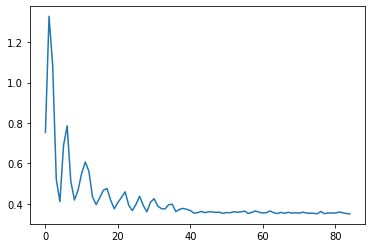

In [485]:
plt.plot(losses[:])

In [486]:
X_train.shape

torch.Size([32561, 123])

In [487]:
t_size = int(math.ceil(1.0/Δt))
ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 100
Θ_0 = torch.zeros((no_posterior_samples, net.dim)).to(device)

Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

(array([ 4., 10., 17., 16., 23., 13., 11.,  1.,  2.,  3.]),
 array([-0.24733813, -0.15700565, -0.06667317,  0.02365931,  0.11399179,
         0.20432428,  0.29465675,  0.38498923,  0.4753217 ,  0.56565416,
         0.65598667], dtype=float32),
 <BarContainer object of 10 artists>)

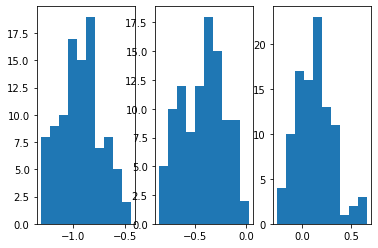

In [488]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.hist(Θ_1[:,0].cpu().detach().numpy())
ax2.hist(Θ_1[:,1].cpu().detach().numpy())
ax3.hist(Θ_1[:,2].cpu().detach().numpy())

In [489]:
def predc(X, Θ):
    return torch.vstack([torch.sigmoid(net.forward(X, θ)[None,...]) for θ in Θ]).mean(dim=0)

In [490]:
pred = predc(X_train, Θ_1)

In [491]:

((pred > 0.5).float().flatten()== y_train).float().mean()

tensor(0.8454, device='cuda:0')

In [492]:
pred_test = predc(X_test.float(), Θ_1)

In [493]:
((pred_test > 0.5).float().flatten() == y_test).float().mean()

tensor(0.8501, device='cuda:0')

## MAP Baseline

We run the point estimate approximation (Maximum a posteriori) to double check what the learned weights look like.  We get the  exact same training accuracy as with the controlled model and similarly large weights for the non bias weights. 

In [10]:
Θ_map = torch.zeros((1, dim), requires_grad=True, device=device)
optimizer_map = torch.optim.Adam([Θ_map], lr=0.05)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)

losses_map = []
num_steps = 1000
for i in tqdm(range(num_steps)):
    optimizer_map.zero_grad()

    if isinstance(optimizer_map, torch.optim.LBFGS):
        def closure_map():
            loss_map = log_likelihood_vmap()
            optimizer_map.zero_grad()
            loss_map.backward()
            return loss

        optimizer_map.step(closure_map)
        losses_map.append(closure_map().item())
    else:
        loss_map = -(log_likelihood_vmap(Θ_map, X_train, y_train) + gaussian_prior(Θ_map))
        optimizer_map.zero_grad()
        loss_map.backward()
        print(loss_map.item())
        optimizer_map.step()
        losses_map.append(loss_map.item())

Θ_map
pred_map = torch.sigmoid(X_train.mm(Θ_map.T)).mean(axis=1)
((pred_map < 0.5).float() == y_train).float().mean(), Θ_map

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\vargf\AppData\Local\Temp/ipykernel_2136/381526447.py:36: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_loss =  torch._vmap_internals.vmap(loss_)


55.45177459716797
52.67886734008789
50.03776931762695
47.52959442138672
45.154483795166016
42.91158676147461
40.79913330078125
38.81449508666992
36.95428466796875
35.21445083618164
33.590423583984375
32.07719421386719
30.66946029663086
29.36173439025879
28.148420333862305
27.023902893066406
25.982643127441406
25.019207000732422
24.128328323364258
23.30495262145996
22.54424476623535
21.841611862182617
21.192726135253906
20.593515396118164
20.040164947509766
19.529117584228516
19.057064056396484
18.620927810668945
18.21786880493164
17.845247268676758
17.500642776489258
17.181812286376953
16.886699676513672
16.613401412963867
16.360179901123047
16.12543487548828
15.907696723937988
15.705615997314453
15.517951011657715
15.343571662902832
15.181438446044922
15.030595779418945
14.890161514282227
14.759340286254883
14.637393951416016
14.523643493652344
14.417470932006836
14.318305969238281
14.225625991821289
14.13895034790039
14.057838439941406
13.981886863708496
13.910720825195312
13.8439960

12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634

(tensor(0., device='cuda:0'),
 tensor([[ 0.0000,  2.4463, -2.1438]], device='cuda:0', requires_grad=True))